            Year       Revenue          Cost
2023-12-31  2023  2.268000e+10  1.222000e+10
2022-12-31  2022  2.360100e+10  1.299800e+10
2021-12-31  2021  1.643400e+10  8.505000e+09
2020-12-31  2020  9.763000e+09  5.416000e+09
2019-12-31  2019           NaN           NaN
X:             Year  Time
2023-12-31  2023     0
2022-12-31  2022     1
2021-12-31  2021     2
2020-12-31  2020     3
2019-12-31  2019     4
Revenue: [2.2680e+10 2.3601e+10 1.6434e+10 9.7630e+09 9.7630e+09]
Cost: [1.2220e+10 1.2998e+10 8.5050e+09 5.4160e+09 5.4160e+09]
Future Linear Revenue: [2.83498e+10 3.23170e+10 3.62842e+10 4.02514e+10 4.42186e+10]
Future Multiple Revenue: 0    4.618922e+09
1    6.758293e+08
2   -3.267263e+09
3   -7.210356e+09
4   -1.115345e+10
dtype: float64
Future Linear Cost: [1.5268e+10 1.7387e+10 1.9506e+10 2.1625e+10 2.3744e+10]
Future Multiple Cost: 0    2.593002e+09
1    4.870021e+08
2   -1.618997e+09
3   -3.724997e+09
4   -5.830996e+09
dtype: float64
   Year  Linear_Revenue  Multiple_Revenue

C:\Users\RichardsPC\AppData\Local\Temp\ipykernel_335680\1700859708.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_data.fillna(method='ffill', inplace=True)


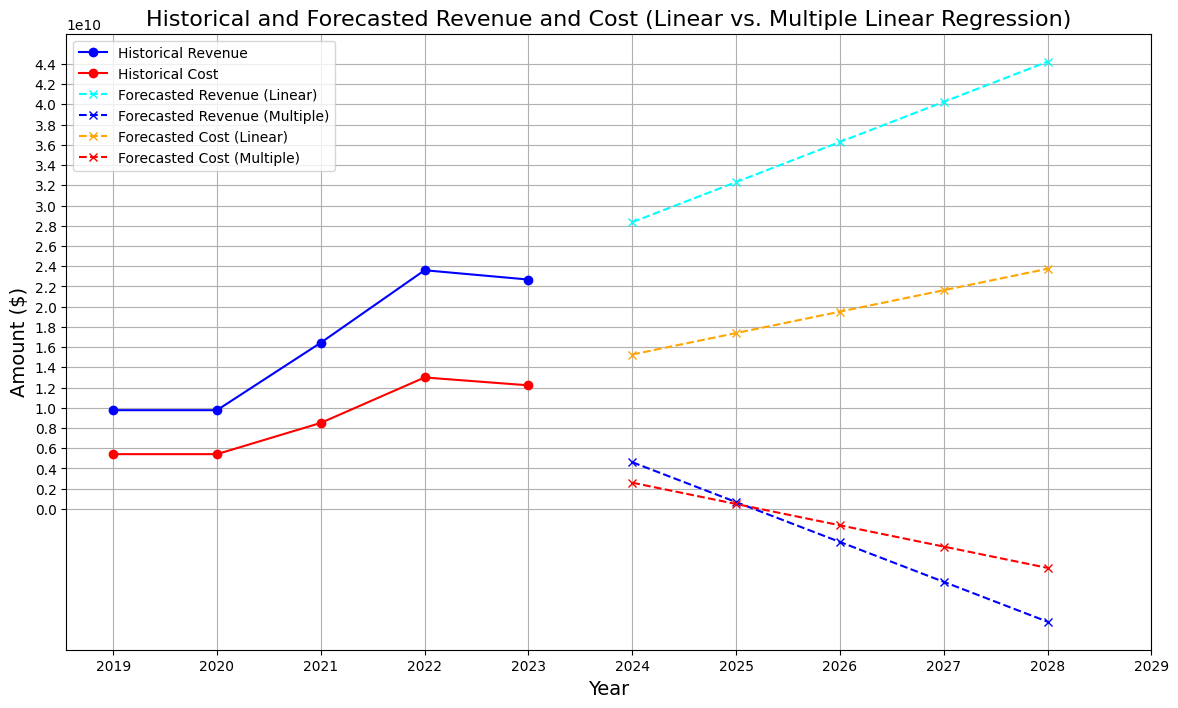

In [24]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Define the ticker symbol
ticker_symbol = 'amd'
ticker = yf.Ticker(ticker_symbol)

# Fetch financial statements
financials = ticker.financials.transpose()

# Extract revenue and cost data
historical_revenue = financials['Total Revenue'].astype(float)
historical_cost = financials['Cost Of Revenue'].astype(float)

# Create a DataFrame for historical data with proper year indexing
years = financials.index.year
historical_data = pd.DataFrame({
    'Year': years,
    'Revenue': historical_revenue,
    'Cost': historical_cost
})

print(historical_data)

# Forward fill NaN values
historical_data.fillna(method='ffill', inplace=True)

# Check for NaN values in historical data
if historical_data.isnull().values.any():
    print("NaN values found in historical data. Please check the input data.")
else:
    # Prepare the data for multiple linear regression
    historical_data['Time'] = np.arange(len(historical_data))  # Adding a time variable
    X = historical_data[['Year', 'Time']]
    revenue = historical_data['Revenue'].values
    cost = historical_data['Cost'].values

    # Ensure no NaN values in historical data
    print(f'X: {X}')
    print(f'Revenue: {revenue}')
    print(f'Cost: {cost}')

    # Linear regression model for revenue
    X_linear_revenue = sm.add_constant(historical_data['Year'])
    model_linear_revenue = sm.OLS(revenue, X_linear_revenue).fit()
    future_years = np.arange(historical_data['Year'].max() + 1, historical_data['Year'].max() + 6)
    X_future_linear_revenue = sm.add_constant(future_years)
    future_linear_revenue = model_linear_revenue.predict(X_future_linear_revenue)

    # Multiple Linear regression model for revenue
    X_multiple_revenue = sm.add_constant(X)
    model_multiple_revenue = sm.OLS(revenue, X_multiple_revenue).fit()
    future_time = np.arange(len(historical_data), len(historical_data) + len(future_years))
    X_future_multiple_revenue = pd.DataFrame({
        'Year': future_years,
        'Time': future_time
    })
    X_future_multiple_revenue = sm.add_constant(X_future_multiple_revenue)
    future_multiple_revenue = model_multiple_revenue.predict(X_future_multiple_revenue)

    # Linear regression model for cost
    X_linear_cost = sm.add_constant(historical_data['Year'])
    model_linear_cost = sm.OLS(cost, X_linear_cost).fit()
    X_future_linear_cost = sm.add_constant(future_years)
    future_linear_cost = model_linear_cost.predict(X_future_linear_cost)

    # Multiple Linear regression model for cost
    X_multiple_cost = sm.add_constant(X)
    model_multiple_cost = sm.OLS(cost, X_multiple_cost).fit()
    X_future_multiple_cost = pd.DataFrame({
        'Year': future_years,
        'Time': future_time
    })
    X_future_multiple_cost = sm.add_constant(X_future_multiple_cost)
    future_multiple_cost = model_multiple_cost.predict(X_future_multiple_cost)

    # Ensure no NaN values in future predictions
    print(f'Future Linear Revenue: {future_linear_revenue}')
    print(f'Future Multiple Revenue: {future_multiple_revenue}')
    print(f'Future Linear Cost: {future_linear_cost}')
    print(f'Future Multiple Cost: {future_multiple_cost}')

    # Check for NaN values in predictions
    if np.any(np.isnan(future_linear_revenue)) or np.any(np.isnan(future_multiple_revenue)) or \
       np.any(np.isnan(future_linear_cost)) or np.any(np.isnan(future_multiple_cost)):
        print("NaN values found in future predictions. Please check the input data and model configuration.")
    else:
        # Create DataFrame for predictions
        forecast_df = pd.DataFrame({
            'Year': np.concatenate([years, future_years]),
            'Linear_Revenue': np.concatenate([revenue, future_linear_revenue]),
            'Multiple_Revenue': np.concatenate([revenue, future_multiple_revenue]),
            'Linear_Cost': np.concatenate([cost, future_linear_cost]),
            'Multiple_Cost': np.concatenate([cost, future_multiple_cost])
        })

        print(forecast_df)

        # Plot the predictions
        plt.figure(figsize=(14, 8))

        # Plot historical data
        plt.plot(forecast_df['Year'][:len(years)], forecast_df['Linear_Revenue'][:len(years)], label='Historical Revenue', marker='o', color='blue')
        plt.plot(forecast_df['Year'][:len(years)], forecast_df['Linear_Cost'][:len(years)], label='Historical Cost', marker='o', color='red')

        # Plot forecasted data
        plt.plot(forecast_df['Year'][len(years):], forecast_df['Linear_Revenue'][len(years):], label='Forecasted Revenue (Linear)', linestyle='--', marker='x', color='cyan')
        plt.plot(forecast_df['Year'][len(years):], forecast_df['Multiple_Revenue'][len(years):], label='Forecasted Revenue (Multiple)', linestyle='--', marker='x', color='blue')
        plt.plot(forecast_df['Year'][len(years):], forecast_df['Linear_Cost'][len(years):], label='Forecasted Cost (Linear)', linestyle='--', marker='x', color='orange')
        plt.plot(forecast_df['Year'][len(years):], forecast_df['Multiple_Cost'][len(years):], label='Forecasted Cost (Multiple)', linestyle='--', marker='x', color='red')

        # Enhance x-axis and y-axis
        plt.xticks(np.arange(2019, 2030, 1))
        plt.yticks(np.arange(0, max(max(forecast_df['Linear_Revenue']), max(forecast_df['Multiple_Revenue'])) + 20000000, 2000000000))

        # Add titles and labels
        plt.title('Historical and Forecasted Revenue and Cost (Linear vs. Multiple Linear Regression)', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Amount ($)', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()
